### Full Name : ADEL MOVAHEDIAN
### Student Number : 400102074


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [2]:
def explore_data(data_loader):
    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Plot sample images
    fig, axes = plt.subplots(1, 10, figsize=(12, 2))
    fig.suptitle('Sample Images')

    for i in range(10):
        img = images[i].squeeze().numpy()  # Remove batch dimension and convert to numpy (squeeze func remove dimensions of 1)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Label: {labels[i].item()}')
    plt.show()


    all_labels = []
    for _, lbls in data_loader:
        all_labels.extend(lbls.numpy())

    plt.hist(all_labels, bins=np.arange(11) - 0.5, edgecolor='black')
    plt.xticks(range(10))
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 796041.88it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 211016.47it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 678158.55it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3294229.43it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



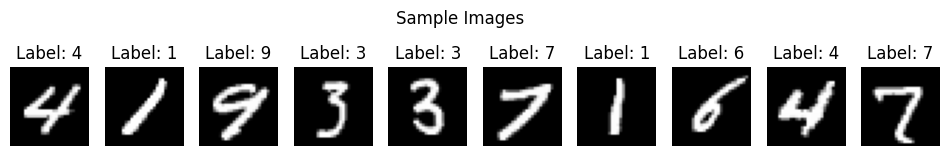

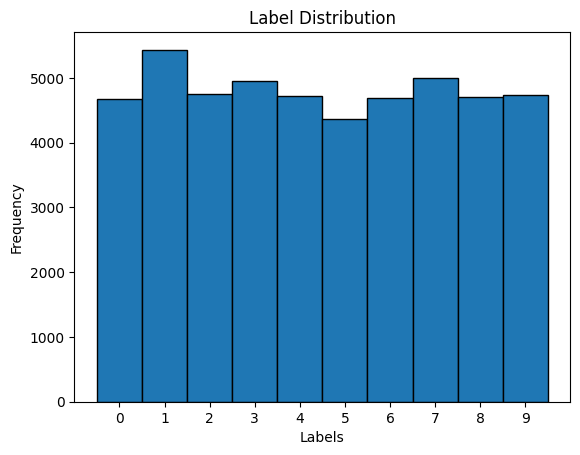

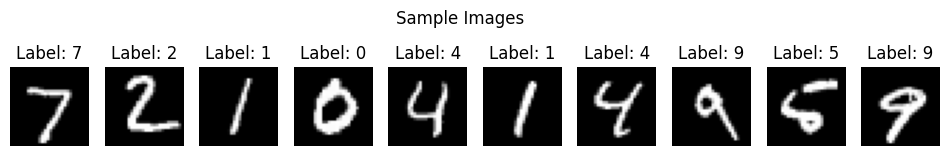

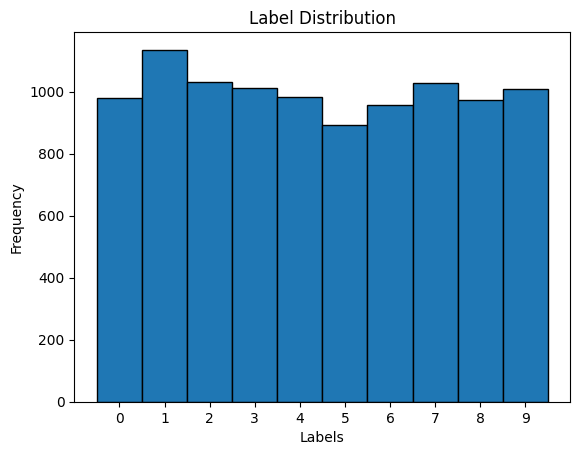

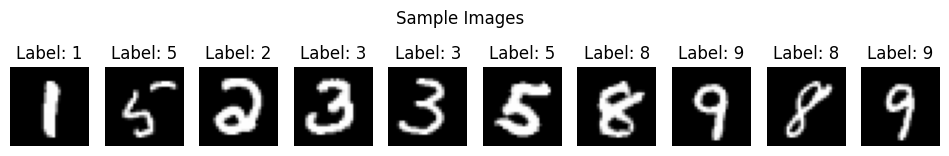

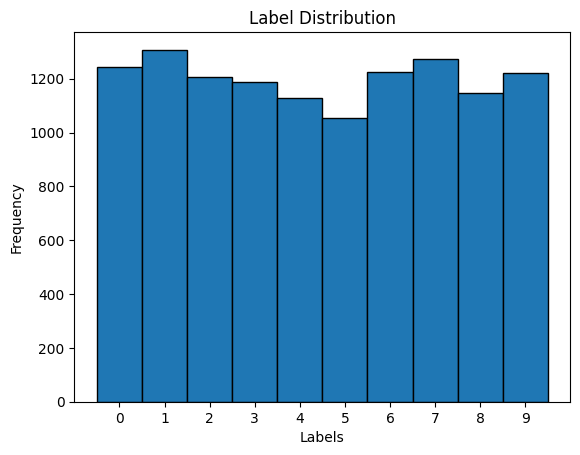

In [3]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [4]:
def prepare_data_for_cart(data_loader):
    X, y = [], []
    for images, labels in data_loader:
        # We should Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 784) to have a long array
        flattened_images = images.view(images.size(0), -1)  # Flattening the images
        X.append(flattened_images.numpy())  # Convert to NumPy and append to X for the calculations
        y.append(labels.numpy())  # Append labels to y

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

    return X, y

In [5]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

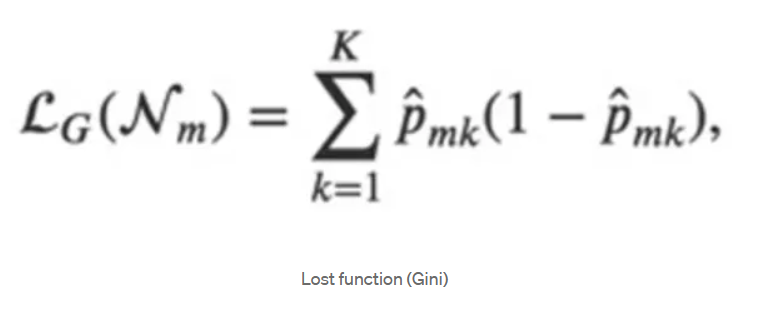

In [14]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=12, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        #recursive tree building
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        #control exploration
        if depth >= self.max_depth or num_samples < self.min_samples_split or num_labels == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._find_best_split(X, y)
        
        if best_feature is None:
            # we have a leaf node when no more splits are available
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Split into left and right branche
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left_node = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1) # +1 for recursive call
        right_node = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1) # +1 for recursive call

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node)


    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = float('inf')  # start with the infinity gini
        best_feature, best_threshold = None, None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_idxs, right_idxs = self._split(X[:, feature_idx], threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                #Gini impurity for this split
                gini = self._gini_impurity_split(y[left_idxs], y[right_idxs])

                # Updating
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _split(self, feature_column, threshold):
        left_idxs = np.where(feature_column <= threshold)[0]
        right_idxs = np.where(feature_column > threshold)[0]
        return left_idxs, right_idxs

    def _gini_impurity(self, y):
        m = len(y)
        if m == 0:
            return 0
        class_counts = np.bincount(y)
        probabilities = class_counts / m
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _gini_impurity_split(self, left_y, right_y):
        m = len(left_y) + len(right_y)
        gini_left = self._gini_impurity(left_y)
        gini_right = self._gini_impurity(right_y)
        weighted_gini = (len(left_y) / m) * gini_left + (len(right_y) / m) * gini_right
        return weighted_gini

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)



## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

X_train, y_train = prepare_data_for_cart(train_loader)

tree = DecisionTree_CART(max_depth=6)
tree.fit(X_train, y_train)

X_test, y_test = prepare_data_for_cart(test_loader)
predictions = tree.predict(X_test)

accuracy_cart = accuracy_score(y_test, predictions)
print(f"Accuracy of custom CART on test set: {accuracy_cart:.4f}")



Accuracy of custom CART on test set: 0.7474


In [18]:
#scikit-learn's DecisionTreeClassifier
sklearn_tree = DecisionTreeClassifier(max_depth=6)
sklearn_tree.fit(X_train, y_train)

#Predict with scikit-learn
sklearn_predictions = sklearn_tree.predict(X_test)

#Calculate accuracy
accuracy_sklearn = accuracy_score(y_test, sklearn_predictions)
print(f"Accuracy of scikit-learn DecisionTree on test set: {accuracy_sklearn:.4f}")


Accuracy of scikit-learn DecisionTree on test set: 0.7472


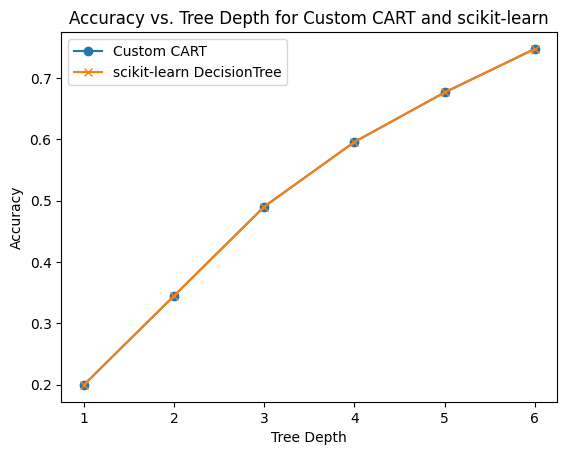

In [26]:
depths = list(range(1, 7))  
cart_accuracies = []
sklearn_accuracies = []

for depth in depths:
    tree = DecisionTree_CART(max_depth=depth)
    tree.fit(X_train, y_train)
    cart_predictions = tree.predict(X_test)
    cart_accuracies.append(accuracy_score(y_test, cart_predictions))

    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_predictions))

plt.plot(depths, cart_accuracies, label='Custom CART', marker='o')
plt.plot(depths, sklearn_accuracies, label='scikit-learn DecisionTree', marker='x')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth for Custom CART and scikit-learn')
plt.legend()
plt.show()


these two algorithms are apparently the same and to see difference more clear we should increase the depth a lot this run cant be performed on my pc but the accuracy of those two models are different that has been shown previously.

## Question
What is the difference between ID3 and CART algorithm

### 1. **Purpose**:
   - **ID3** is like a specialized tool for **classification** tasks. It builds decision trees to help sort data into categories. For example, if we are trying to classify whether an animal is a cat or a dog based on its features, ID3 can help.
   - **CART**, on the other hand, is a versatile tool. It’s not just for classification; it can also handle **regression** tasks, meaning it can predict numbers. So, if you wanted to predict the price of a house based on its features, CART would be your go-to.

### 2. **Splitting Criterion**:
   - **ID3** chooses which way to split the data by looking at **information gain**. Think of it as trying to figure out which questions give us the most useful information to narrow things down. It uses something called **entropy** to measure uncertainty.
   - **CART** takes a different approach. For classification, it uses the **Gini index** to gauge how “mixed” the data is at a split, while for regression, it focuses on **Mean Squared Error (MSE)** to minimize prediction errors. It's like trying to clean up a messy room by deciding which area to tackle first.

### 3. **Data Handling**:
   - **ID3** works best with **categorical data**. If we want to use numbers, we'll need to break them down into categories first (like age ranges). Imagine sorting people into age groups instead of dealing with exact ages.
   - **CART** is more flexible. It can handle both **categorical and numerical data** without needing any pre-processing. So, you can feed it raw data, and it’ll work with it.

### 4. **Splits**:
   - **ID3** can make **multiway splits**. If we have a feature with several values (like colors: Red, Green, Blue), ID3 can create branches for each color.
   - **CART**, however, only does **binary splits**. Every decision point divides the data into two groups, making it a bit simpler and more structured.

### 5. **Pruning**:
   - **ID3** doesn't include a built-in way to trim back the tree once it’s built. This can sometimes lead to **overfitting**, where the model learns too much from the training data and struggles with new data.
   - **CART** has a built-in **pruning** method called **cost-complexity pruning**. This helps trim back unnecessary branches, ensuring the tree is just the right size to make accurate predictions without being overly complex.

### 6. **Tree Structure**:
   - **ID3** creates **multiway trees**, meaning nodes can have multiple branches. Picture a tree where one question leads to several possible answers.
   - **CART** builds a **binary tree**, where every node has only two branches. It’s more straightforward, kind of like a yes/no question path.

### 7. **Use Cases**:
   - **ID3** is perfect for situations where you need to categorize things, like identifying types of fruit based on color and size.
   - **CART** is a better choice when you need flexibility, whether we are classifying types of customers or predicting sales figures.
